<div style="border:2px solid black; padding:10px;">
    <h3>Nhóm 15</h3>
    <h1 style='color:red;text-align:center;font-size:30px'>Chủ đề: Phân tích về doanh thu phim<b></b></h1>
</div>


<h3>Danh sách thành viên</h3>
<li> Nguyễn Quốc Hưng - 21120464 </li>
<li> Đoàn Đức Hữu - 21120465 </li>
<li> Võ Minh Khuê - 21120486</li>
<li> Hồ Trọng Lễ - 21120494</li>

<h1 style='color:blue;text-align:center;font-size:30px'><b>Phần II</b></h1>

# Import thư viện

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_theme()
import os
import re
import statistics
import seaborn as sns
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgray'})

In [2]:
import sys
sys.executable

'/home/khuevo098/miniconda3/envs/min_ds-env/bin/python'

## Đọc file 'processed_data' vào dataframe df

In [3]:
movies_df = pd.read_csv('./data/processed/processed_data.csv')
movies_df.head(10)

,title,domestic_revenue,world_revenue,distributor,opening_revenue,MPAA,genres,running_time,in_release,release_date
0,Batman Returns,162831698,266831698,Warner Bros.,45687711.0,PG-13,"Action,Crime,Fantasy",126.0,196.0,1992-06-19
1,Evolution,38345494,98376292,DreamWorks Distribution,13408351.0,PG-13,"Comedy,Sci-Fi",101.0,207.0,2001-06-08
2,Jumanji,100475249,100475249,Sony Pictures Entertainment (SPE),11084370.0,PG,"Adventure,Comedy,Family,Fantasy",104.0,383.0,1995-12-15
3,The American President,60079496,60079496,Sony Pictures Entertainment (SPE),10014558.0,PG-13,"Comedy,Drama,Romance",114.0,411.0,1995-11-17
4,Mulholland Drive,7220243,20117339,Universal Pictures,587591.0,R,"Drama,Mystery,Thriller",147.0,450.0,2001-10-08
5,Tombstone,56505065,56505065,Walt Disney Studios Motion Pictures,6454752.0,R,"Biography,Drama,History,Western",130.0,373.0,1993-12-24
6,Heart and Souls,16589540,16589540,Universal Pictures,4322250.0,PG-13,"Comedy,Drama,Fantasy,Romance",104.0,141.0,1993-08-13
7,The Phantom of the Opera,51268815,154648887,Warner Bros.,4001890.0,PG-13,"Drama,Musical,Romance,Thriller",143.0,375.0,2004-12-22
8,The Brady Bunch Movie,46576136,46576136,Paramount Pictures,14827066.0,PG-13,Comedy,90.0,318.0,1995-02-17
9,Teenage Mutant Ninja Turtles III,42273609,42273609,New Line Cinema,12419597.0,PG,"Action,Adventure,Comedy,Family,Fantasy,Sci-Fi",96.0,288.0,1993-03-19


<h2 style='color:#32a852;text-align:center;font-size:25px'><b>A. Mô hình hóa dữ liệu</b></h2> 

In [4]:
# Data Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

<h2 style='color:#32a852;text-align:center;font-size:25px'><b>B. Đánh giá mô hình</b></h2> 

### Bài toán đặt ra
- Một bộ phim có các thuộc tính của phim như thể loại, sự giới hạn độ tuổi, thời lượng phim hay là các nhà sản xuất phim,...Liệu chúng ta có thể đánh giá tổng doanh thu của bộ phim đó thông qua những thuộc tính trên không?
### Hướng giải quyết
- Chọn các thuộc tính phù hợp để tiến hành đánh giá mô hình.
- Chọn `world_revenue` làm biến mục tiêu.
- Lựa chọn các thuật toán cho mô hình.
- Tinh chỉnh mô hình và đánh giá mô hình của từng thuật toán.
- Chọn thuật toán tốt nhất để triển khai mô hình.
### Thuật toán sử dụng:
- Random Forest Classifier(RF)
- K-Nearest Neighbor(KNN)

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Hàm tính phi hệ số Cramér cho cặp biến
def cramers_v(var1, var2):
    contingency_table = pd.crosstab(movies_df[var1], movies_df[var2])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.values.sum()
    v = np.sqrt(chi2 / (n * min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)))
    return v

# Tính phi hệ số Cramér cho tất cả các cặp biến trong DataFrame
columns = movies_df.columns
cramers_matrix = pd.DataFrame(index=columns, columns=columns)

for var1 in columns:
    for var2 in columns:
        cramers_matrix.loc[var1, var2] = cramers_v(var1, var2)
cramers_matrix

,title,domestic_revenue,world_revenue,distributor,opening_revenue,MPAA,genres,running_time,in_release,release_date
title,1.0,1.0,1.0,0.991538,0.999144,0.989278,0.995482,0.993828,0.98883,0.990519
domestic_revenue,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
world_revenue,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
distributor,0.991538,1.0,1.0,1.0,0.999731,0.456466,0.479133,0.202594,0.338967,0.615526
opening_revenue,0.999144,1.0,1.0,0.999731,1.0,0.999672,0.999478,0.998617,0.999528,0.99919
MPAA,0.989278,1.0,1.0,0.456466,0.999672,1.0,0.700623,0.299357,0.320513,0.638232
genres,0.995482,1.0,1.0,0.479133,0.999478,0.700623,1.0,0.476132,0.43354,0.621265
running_time,0.993828,1.0,1.0,0.202594,0.998617,0.299357,0.476132,1.0,0.365101,0.669692
in_release,0.98883,1.0,1.0,0.338967,0.999528,0.320513,0.43354,0.365101,1.0,0.895791
release_date,0.990519,1.0,1.0,0.615526,0.99919,0.638232,0.621265,0.669692,0.895791,1.0


#### Trực quan hóa ma trận trên:

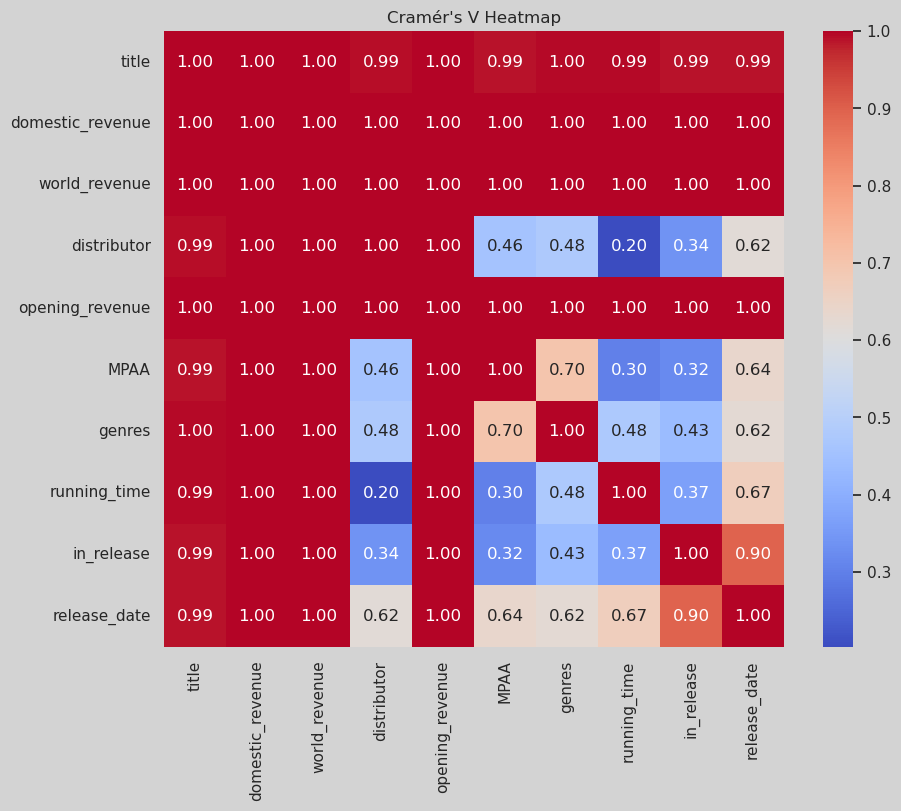

In [6]:
copy = cramers_matrix.copy()
copy = copy.astype(float)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(copy, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramér's V Heatmap")
plt.show()

#### Từ ma trận thể hiện độ tương quan giữa mỗi giữa các biến trong tập dữ liệu, ta thấy:
- `title`, `domestic_revenue`, `world_revenue`, `opening_revenue`: mức độ tương quan giữa từng cặp biến này `rất cao(mức tuyệt đối)`. Cho nên nhóm đã loại bỏ chúng ra khỏi tập đặc trưng của mô hình bởi vì chúng hoàn toàn `tuyến tính phụ thuộc lẫn nhau`, dẫn đến hiện tượng `"multicollinearity"`(tăng phương sai của các ước lượng và mô hình sẽ dự đoán sai) trong mô hình.
- `in_release` và `release_date` có mối tương quan với nhau cũng khá cao nên nhóm sẽ loại bỏ đi một trong hai chúng. Nhóm sẽ bỏ đi `release_date`.
- Cuối cùng, cột `MPAA`, `genres`, `running_time` và `in_release` sẽ được chọn làm `đặc trưng` của mô hình.

### Tiền xử lí dữ liệu

In [7]:
copy_df = movies_df[['distributor', 'MPAA','genres','running_time','in_release']]

In [8]:
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4760 entries, 0 to 4759
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distributor   4760 non-null   object 
 1   MPAA          4760 non-null   object 
 2   genres        4760 non-null   object 
 3   running_time  4760 non-null   float64
 4   in_release    4760 non-null   float64
dtypes: float64(2), object(3)
memory usage: 186.1+ KB


`Bước 1`: Kiểm tra có cột nào bị thiếu dữ liệu không?

In [9]:
total = copy_df.isnull().sum().sort_values(ascending=False)
percent = (copy_df.isnull().sum()/copy_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.T

,distributor,MPAA,genres,running_time,in_release
Total,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0


`Bước 2`: Xử lí các cột categorial `distributor`, `MPAA` và `genres`.
- Áp dụng `Label Encoding` cho distributor và MPAA của copy_df.
- Áp dụng `One-hot Encoding` cho genres tạo ra genres_encoded.
- Sau đó dùng `pd.concat` để ghép genres_encoded với copy_df rồi drop cột genres đi.

In [10]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    copy_df[col] = le.fit_transform(copy_df[col])

/tmp/ipykernel_1341/4102794415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df[col] = le.fit_transform(copy_df[col])
/tmp/ipykernel_1341/4102794415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df[col] = le.fit_transform(copy_df[col])


In [11]:
genres_encoded = copy_df['genres'].str.get_dummies(',')
copy_df = pd.concat([genres_encoded,copy_df], axis=1)
copy_df = copy_df.drop(['genres'], axis=1)

`Bước 3`: Tạo biến mục tiêu

In [12]:
threshold = movies_df['world_revenue'].quantile(0.75)
threshold
copy_df['label'] = movies_df['world_revenue'].apply(lambda x: 1 if x > threshold else 0)

In [13]:
X = copy_df.drop(['label'], axis=1)
y = copy_df['label']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỉ lệ là 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Chuẩn hóa dữ liệu

In [14]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Các mô hình phân loại

### Mô hình 1: Random Forest Classifier

In [15]:
metric = {}

In [16]:
#Fitting the Model
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

#Evaluating the Model
rf_pred = classifier.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
metric['RF'] = [rf_accuracy,rf_precision,rf_recall]

Accuracy: 0.8179271708683473
Precision: 0.7208333333333333
Recall: 0.4726775956284153


### Mô hình 2: K-Nearest Neighbor

In [17]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
metric['KNN'] = [knn_accuracy,knn_precision,knn_recall]

Accuracy: 0.7941176470588235
Precision: 0.6463414634146342
Recall: 0.4344262295081967


In [18]:
before_metric = pd.DataFrame(metric)
before_metric.index = ['Accuracy', 'Precision', 'Recall']
before_metric

,RF,KNN
Accuracy,0.817927,0.794118
Precision,0.720833,0.646341
Recall,0.472678,0.434426


### Tinh chỉnh mô hình

#### Tinh chỉnh mô hình Random Forest Classifier bằng kỹ thuật cross-validation
Ở task này, nhóm tiến hành tìm kiếm siêu tham số ngẫu nhiên (Randomized Search) để tối ưu hóa mô hình Random Forest Classifier.
- Đầu tiên tạo siêu tham số ngẫn nhiên `param_dict`, các siêu tham số này được xác định thông qua hàm `randint(a, b)`, do đó trong mỗi lần thử nghiệm mỗi siêu tham số này sẽ được chọn ngẫu nhiên từ phân phối đều giữa `a` và `b` do hàm `randint` tạo ra. Trong đó:
  - `n_estimators`: số lượng cây quyết định trong rừng. Số cây càng lớn có thể cải thiện hiệu suất của mô hình nhưng cũng làm tăng chi phí tính toán.
  - `max_depth`: độ sâu tối đa của mỗi cây quyết định trong rừng. Siêu tham số này dùng để kiểm soát độ phức tạp của mỗi cây. Độ sâu càng lớn có thể làm mô hình trở nên phức tạp và dễ bị overfitting.
  - `min_samples_split`: số mẫu tối thiểu để chia một nút nội tại để phép phân chia có thể được thực hiện. Nếu số lượng mẫu trong nút ít hơn siêu tham số này, nút sẽ không được phân chia và nó sẽ trở thành một lá(hoặc dừng lại nếu đáp ứng được các điều kiện dừng khác).
  - `min_samples_leaf`: số lượng mẫu tối thiểu ở mỗi lá nghĩa là số lượng mẫu tối thiểu mà lá đó cần phải chứa. Nếu sau mỗi lần phân chia một lá có ít mẫu hơn siêu tham số này thì cây sẽ không tiếp tục phân chia và lá sẽ được dừng lại.
  - `min_samples_split` và `min_samples_leaf` giúp kiểm soát độ phức tạp của cây và giảm nguy cơ `overfitting`.

In [19]:
# Thêm các siêu tham số khác vào param_dist
param_dist = {'n_estimators': randint(50, 500),
              'max_depth': randint(1, 20),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 5)}

- Bước này nhóm tiến hành tạo mô hình `Random Forest Classifier` là `rf`, sau đó sử dụng `RandomizedSearchCV` để train các mô hình(được định nghĩa bởi tham số `n_iter`) và lưu chúng vào `rand_search`. Từ `rand_search`, dùng `best_estimator_` để tìm mô hình tốt nhất trong số các mô hình mà hàm RandomizedSearchCV vừa train. 
- Hơn nữa, `RandomizedSearchCV` còn sử dụng kỹ thuật `5-fold cross-validation` diễn ra như sau:
  1. `Chia dữ liệu`: chia dữ liệu thành 5 phần bằng nhau.
  2. `Lặp 5 lần`: lần lượt mỗi fold được chọn làm tập kiểm thử và các fold còn lại được sử dụng để huấn luyện mô hình
  3. `Huấn luyện và đánh giá`: mô hình được huấn luyện trên `4 fold`(được gọi là tập huấn luyện) và đánh giá trên `fold còn lại`(tập kiểm thử). Qúa trình này được lặp `5 lần`, mỗi lần sẽ chọn một fold khác nhau làm tập test còn 4 tập kia thì train.
  4. `Tổng hợp kết quả`: kết quả của 5 lần đánh giá từ bước 3 sẽ được tổng hợp để đưa ra kết quả cuối cùng, chính là mô hình tốt nhất.
- `best_params_` được dùng để lấy các siêu tham số của mô hình tốt nhất đó.

In [20]:
# Tạo mô hình Random Forest Classifier
rf = RandomForestClassifier()

# Sử dụng RandomizedSearchCV để tìm kiếm siêu tham số
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit đối tượng tìm kiếm ngẫu nhiên vào dữ liệu
rand_search.fit(X_train, y_train)

# Print the best hyperparameters
best_rf_params = rand_search.best_params_
print("Các siêu tham số tốt nhất:", best_rf_params)

# Get the best model
best_classifier = rand_search.best_estimator_

# Make predictions on the test set
rf_fined_pred = best_classifier.predict(X_test)

# Evaluate the model
rf_fined_accuracy = accuracy_score(y_test, rf_fined_pred)
rf_fined_precision = precision_score(y_test, rf_fined_pred)
rf_fined_recall = recall_score(y_test, rf_fined_pred)

print("Accuracy:", rf_fined_accuracy)
print("Precision:", rf_fined_precision)
print("Recall:", rf_fined_recall)
metric['Fined RF'] = [rf_fined_accuracy,rf_fined_precision,rf_fined_recall]

Các siêu tham số tốt nhất: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 497}
Accuracy: 0.8235294117647058
Precision: 0.796875
Recall: 0.4180327868852459


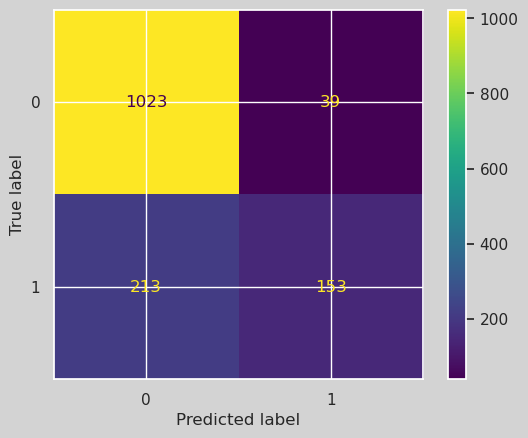

In [21]:
# Generate predictions with the best model
y_pred = best_classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

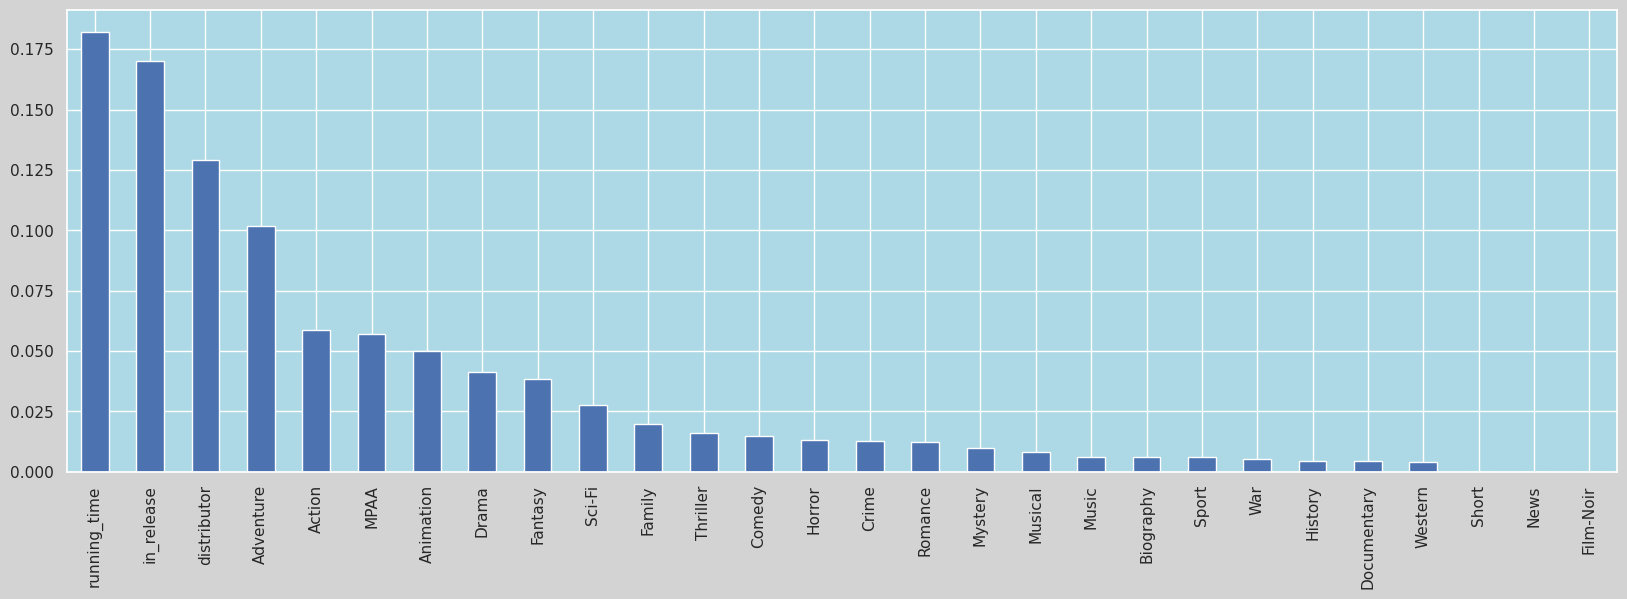

In [22]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 6))

# Vẽ đồ thị cột
feature_importances.plot.bar()

# Hiển thị đồ thị
plt.show()

https://www.datacamp.com/tutorial/random-forests-classifier-python

#### Tinh chỉnh mô hình K-Nearest Neighbor bằng kỹ thuật cross-validation

- Trong mô hình `K-Nearest Neighbor`, tham số `n_neighbors` là tham số quan trọng, nó dùng để xác định số lượng hàng xóm gần nhất mà mô hình sẽ xem xét để cho ra một điểm dữ liệu mới.
- Để tinh chỉnh mô hình K-Nearest Neighbor, chúng ta cần phải tìm ra giá trị k(n_neighbors) `tốt nhất` để tìm ra mô hình KNN `tốt nhất`.
- Đầu tiên, nhóm vạch ra khoảng cho k là `(1,201)`. `Tại sao không lấy k lớn hơn?` Bởi vì nếu `k quá lớn` sẽ xảy ra `overfitting` dẫn đến mô hình trở nên `phức tạp` và `không thể áp dụng` cho dữ liệu mới.
- Chuẩn hóa dữ liệu để `đảm bảo các đặc trưng` đều có cùng mức độ ảnh hưởng với khoảng cách giữa các điểm dữ liệu.
- Thực hiện vòng lặp từ range định nghĩa. Trong mỗi lần lặp:
    - Tạo mô hình KNN với tham số n_neighbors là k hiện tại.
    - Dùng `cross_val_score` để tính độ chính xác bằng cách truyền vào mô hình vừa được tạo, dữ liệu chuẩn hóa X, biến mục tiêu Y và cv = 5 là sử dụng kỹ thuật `5-fold cross-validation` để đánh giá tìm ra độ chính xác.
    - Lưu kết quả vừa tính vào list `scores`.

In [23]:
k_values = [i for i in range (1,201)]
scores = []

sc = StandardScaler()
X = sc.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Trực quan hóa kết quả đánh giá độ chính xác của mô hình theo từng giá trị k

Text(0, 0.5, 'Độ chính xác')

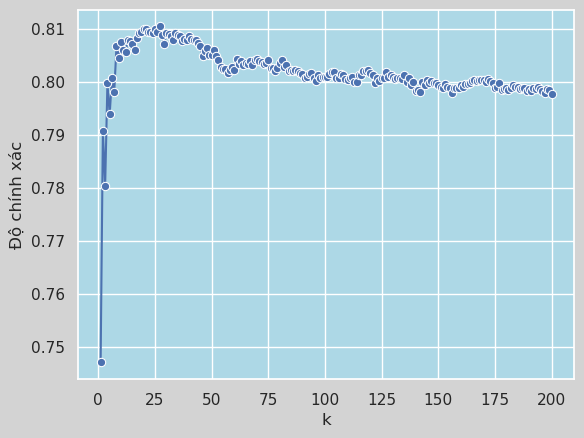

In [24]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("k")
plt.ylabel("Độ chính xác")

Từ biểu đồ trực quan hóa trên, giá trị k tốt nhất nằm gần giữa 27 và 30, để biết chính xác giá trị k, chúng ta sẽ chạy code ở dưới:

In [25]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
print("Gía trị k tốt nhất sau khi tinh chỉnh: k =", best_k)

Gía trị k tốt nhất sau khi tinh chỉnh: k = 27


In [26]:
knn_fined_pred = best_knn.predict(X_test)

knn_fined_accuracy = accuracy_score(y_test, knn_fined_pred)
knn_fined_precision = precision_score(y_test, knn_fined_pred)
knn_fined_recall = recall_score(y_test, knn_fined_pred)


print("Accuracy:", knn_fined_accuracy)
print("Precision:", knn_fined_precision)
print("Recall:", knn_fined_recall)
metric['Fined KNN'] = [knn_fined_accuracy,knn_fined_precision,knn_fined_recall]

Accuracy: 0.8018207282913166
Precision: 0.7106598984771574
Recall: 0.3825136612021858


In [27]:
temp = pd.DataFrame(metric)
temp.index = ['Accuracy', 'Precision', 'Recall']
temp.T

,Accuracy,Precision,Recall
RF,0.817927,0.720833,0.472678
KNN,0.794118,0.646341,0.434426
Fined RF,0.823529,0.796875,0.418033
Fined KNN,0.801821,0.710660,0.382514


### Kết luận:

#### 1. Random Forest (RF):
   - **Accuracy:** 0.817927
   - **Precision:** 0.720833
   - **Recall:** 0.472678
   - Mô hình Random Forest có độ chính xác cao (Accuracy), tốt hơn so với K-Nearest Neighbors (KNN).
   - Precision của mô hình cũng khá tốt, đặc biệt là khả năng đưa ra dự đoán chính xác cho các trường hợp tích cực (Positive). Tuy nhiên, Recall thấp hơn so với Precision, có thể mô hình bỏ sót một số trường hợp tích cực.
#### 2. K-Nearest Neighbors (KNN):
   - **Accuracy:** 0.794118	
   - **Precision:** 0.646341
   - **Recall:** 0.434426
   - Mô hình KNN có độ chính xác thấp hơn so với Random Forest.
   - Precision và Recall cũng thấp hơn so với Random Forest.  
#### 3. Sau khi tinh chỉnh:
   - Sau quá trình tinh chỉnh (fine-tuning), cả hai mô hình đều có sự cải thiện về Accuracy và Precision. Recall thì có sự giảm đi.
     - Accuracy tăng: số lượng True Positives và True Negatives tăng.
     - Precision tăng: số lượng True Positives tăng so với tổng số dự đoán Positive (True Positives + False Positives).
     - Recall giảm: số lượng True Positives giảm so với tổng số thực tế Positive (True Positives + False Negatives).
#### Tóm lại, mô hình Random Forest Classifier có khả năng đưa ra dự đoán tốt hơn mô hình K-Nearest Neighbors.